In [1]:
from moleculekit.molecule import Molecule
import jax_md
import os

testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

2023-05-09 10:55:20,400 - jax._src.lib.xla_bridge - INFO - Remote TPU is not linked into jax; skipping remote TPU.
2023-05-09 10:55:20,406 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-05-09 10:55:20,406 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-09 10:55:20,406 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-09 10:55:20,408 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-05-09 10:55:20,408 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (d

In [2]:
from torchmd.forcefields.forcefield import ForceField



ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))

In [3]:
from parameters import Parameters, set_box, set_positions

In [5]:
parameters = Parameters(ff, mol, precision=float, device='cpu')

pos = set_positions(1, mol.coords)
box = set_box(1, mol.box)

foo
baz
bar


In [13]:
from scipy import constants as const
# import torch
import numpy as np
import numpy.linalg as npl 
import jax.numpy as nnp
import jax.numpy.linalg as nnpl
import jax.lax as lnp
import jax
from math import pi


class Forces:
    """
    Parameters
    ----------
    cutoff : float
        If set to a value it will only calculate LJ, electrostatics and bond energies for atoms which are closer
        than the threshold
    rfa : bool
        Use with `cutoff` to enable the reaction field approximation for scaling of the electrostatics up to the cutoff.
        Uses the value of `solventDielectric` to model everything beyond the cutoff distance as solvent with uniform
        dielectric.
    solventDielectric : float
        Used together with `cutoff` and `rfa`
    """

    # 1-4 is nonbonded but we put it currently in bonded to not calculate all distances
    bonded = ["bonds", "angles", "dihedrals", "impropers", "1-4"]
    nonbonded = ["electrostatics", "lj", "repulsion", "repulsioncg"]
    terms = bonded + nonbonded

    def __init__(
        self,
        parameters,
        terms=None,
        external=None,
        cutoff=None,
        rfa=False,
        solventDielectric=78.5,
        switch_dist=None,
        exclusions=("bonds", "angles", "1-4"),
    ):
        self.par = parameters
        if terms is None:
            raise RuntimeError(
                'Set force terms or leave empty brackets [].\nAvailable options: "bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj", "repulsion", "repulsioncg".'
            )

        self.energies = [ene.lower() for ene in terms]
        for et in self.energies:
            if et not in Forces.terms:
                raise ValueError(f"Force term {et} is not implemented.")

        if "1-4" in self.energies and "dihedrals" not in self.energies:
            raise RuntimeError(
                "You cannot enable 1-4 interactions without enabling dihedrals"
            )

        self.natoms = len(parameters.masses)
        self.require_distances = any(f in self.nonbonded for f in self.energies)
        self.ava_idx = (
            self._make_indeces(
                self.natoms, parameters.get_exclusions(exclusions), parameters.device
            )
            if self.require_distances
            else None
        )
        self.external = external
        self.cutoff = cutoff
        self.rfa = rfa
        self.solventDielectric = solventDielectric
        self.switch_dist = switch_dist

    def _filter_by_cutoff(self, dist, arrays):
        under_cutoff = dist <= self.cutoff
        # indexedarrays = []
        # print(arrays)
        # print(under_cutoff.shape)

        # return jax.lax.cond(len(arrays)==4, 
        #     lambda arr : (arr[0][under_cutoff], arr[1][under_cutoff], arr[2][under_cutoff], arr[3][under_cutoff]) ,  
        #     lambda arr : (arr[0][under_cutoff], arr[1][under_cutoff], arr[2][under_cutoff]) ,  
            
        #     arrays
        #     )

        # todo: maybe inefficient
        return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)
        # return jax.tree_map(lambda arr : arr[under_cutoff], arrays)

        

        # if len(arrays) == 4:
        #     (a, b, c, d) = arrays
        #     return (
        #             a[under_cutoff], 
        #             b[under_cutoff], 
        #             c[under_cutoff], 
        #             d[under_cutoff]
        #             )
        # elif len(arrays) == 3:
        #     (a,b,c) = arrays
        #     return (
        #             a[under_cutoff], 
        #             b[under_cutoff], 
        #             c[under_cutoff] 
        #             )
        # return jax.vmap(lambda x : x[under_cutoff])(arrays)
        # for arr in arrays:
        #     indexedarrays.append(arr[under_cutoff])
        # return indexedarrays

    def compute(self, pos, box):



        nsystems = pos.shape[0]
        # if nnp.any(np.isnan(pos)):
        #     raise RuntimeError("Found NaN coordinates.")

        # pot = []
        # for i in range(nsystems):
        #     pp = {
        #         v: np.zeros((1,))
        #         for v in self.energies
        #     }
        #     pp["external"] = np.zeros((1, ))
        #     pot.append(pp)

        


        
        spos = pos[0]
        sbox = nnp.diagonal(box[0]) # box[0][np.array(nnp.eye(3), dtype=bool)]  # Use only the diagonal

        # Bonded terms
        # TODO: We are for sure doing duplicate distance calculations here!
        if "bonds" in self.energies and self.par.bonds is not None:
            bond_dist, bond_unitvec, _ = calculate_distances(
                spos, self.par.bonds, sbox
            )
            pairs = self.par.bonds
            bond_params = self.par.bond_params
            if self.cutoff is not None:
                (
                    bond_dist,
                    bond_unitvec,
                    pairs,
                    bond_params,
                ) = self._filter_by_cutoff(
                    bond_dist, (bond_dist, bond_unitvec, pairs, bond_params)
                )
            print(bond_dist.shape, bond_params.shape, "shapes")
            E = evaluate_bonds(bond_dist, bond_params)
            
            pot_bonds = E.sum()
        else:
            pot_bonds = 0.0
            # pot[0]["bonds"] += E.sum()

            # return [nnp.sum(nnp.concatenate(list(pp.values()))) for pp in pot]
            
        if "angles" in self.energies and self.par.angles is not None:
            _, _, r21 = calculate_distances(spos, self.par.angles[:, [0, 1]], sbox)
            _, _, r23 = calculate_distances(spos, self.par.angles[:, [2, 1]], sbox)
            E = evaluate_angles(
                r21, r23, self.par.angle_params
            )

            pot_angles = E.sum()
        else:
            pot_angles = 0.0
            
        if "dihedrals" in self.energies and self.par.dihedrals is not None:
            _, _, r12 = calculate_distances(
                spos, self.par.dihedrals[:, [0, 1]], sbox
            )
            _, _, r23 = calculate_distances(
                spos, self.par.dihedrals[:, [1, 2]], sbox
            )
            _, _, r34 = calculate_distances(
                spos, self.par.dihedrals[:, [2, 3]], sbox
            )
            E = evaluate_torsion(
                r12, r23, r34, self.par.dihedral_params
            )

            pot_tor = E.sum()
        else:
            pot_tor = 0.0
            

        if "1-4" in self.energies and self.par.idx14 is not None:
            nb_dist, nb_unitvec, _ = calculate_distances(spos, self.par.idx14, sbox)

            nonbonded_14_params = self.par.nonbonded_14_params
            idx14 = self.par.idx14


            aa = nonbonded_14_params[:, 0]
            bb = nonbonded_14_params[:, 1]
            scnb = nonbonded_14_params[:, 2]
            scee = nonbonded_14_params[:, 3]

            if "lj" in self.energies:
                E = evaluate_LJ_internal(
                    nb_dist, aa, bb, scnb, None, None
                )
                pot_lj = E.sum()
            else:
                pot_lj = 0


            if "electrostatics" in self.energies:
                pot_electrostatics_unsummed = evaluate_electrostatics(
                    nb_dist,
                    idx14,
                    self.par.charges,
                    scee,
                    cutoff=None,
                    rfa=False,
                    solventDielectric=self.solventDielectric
                )
                pot_electrostatics = pot_electrostatics_unsummed.sum()
            else:
                pot_electrostatics = 0.0


        if "impropers" in self.energies and self.par.impropers is not None:
            _, _, r12 = calculate_distances(
                spos, self.par.impropers[:, [0, 1]], sbox
            )
            _, _, r23 = calculate_distances(
                spos, self.par.impropers[:, [1, 2]], sbox
            )
            _, _, r34 = calculate_distances(
                spos, self.par.impropers[:, [2, 3]], sbox
            )
            print("R34", r34.shape, r23.shape, r12.shape)
            E = evaluate_torsion(
                r12, r23, r34, self.par.improper_params
            )

            pot_impropers = E.sum()
        else:
            pot_impropers = 0.0


        # Non-bonded terms
        if self.require_distances and len(self.ava_idx):
            # Lazy mode: Do all vs all distances
            # TODO: These distance calculations are fucked once we do neighbourlists since they will vary per system!!!!
            nb_dist, nb_unitvec, _ = calculate_distances(spos, self.ava_idx, sbox)
            ava_idx = self.ava_idx
            if self.cutoff is not None:
                nb_dist, nb_unitvec, ava_idx = self._filter_by_cutoff(
                    nb_dist, (nb_dist, nb_unitvec, ava_idx)
                )

                if 'electrostatics' in self.energies:
                    pot_electrostatics2_unsummed = evaluate_electrostatics(
                        nb_dist,
                        ava_idx,
                        self.par.charges,
                        cutoff=self.cutoff,
                        rfa=self.rfa,
                        solventDielectric=self.solventDielectric
                    )
                    pot_electrostatics2 = infsum(pot_electrostatics2_unsummed)
                else: pot_electrostatics2 = 0.0


                if 'lj' in self.energies:
                    pot_lj2_unsummed = evaluate_LJ(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.A,
                        self.par.B,
                        self.switch_dist,
                        self.cutoff
                    )
                    pot_lj2 = nnp.sum(pot_lj2_unsummed)
                else:
                    pot_lj2 = 0.0


                if 'repulsion' in self.energies:
                    pot_repulsion_unsummed = evaluate_repulsion(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.A
                    )
                    pot_repulsion = pot_repulsion_unsummed.sum()
                else:
                    pot_repulsion = 0.0
                
                if 'repulsioncg' in self.energies:
                    pot_repulsioncg_unsummed = evaluate_repulsion_CG(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.B
                    )
                    pot_repulsioncg = pot_repulsioncg_unsummed.sum()
                else:
                    pot_repulsioncg = 0.0



        if self.external:
            ext_ene, ext_force = self.external.calculate(pos, box)
            pot_external = ext_ene[0]
        else:
            pot_external = 0


        print(pot_bonds, "pot_bonds")
        print(pot_angles, "pot_angles")
        print(pot_tor, "pot_tor")
        print(pot_lj, "pot_lj")
        print(pot_electrostatics, "pot_electrostatics")
        print(pot_impropers, "pot_impropers")
        print(pot_electrostatics2, "pot_electrostatics2")
        print(pot_lj2, "pot_lj2")
        print(pot_repulsion, "pot_repulsion")
        print(pot_repulsioncg, "pot_repulsioncg")
        print(pot_external, "pot_external")
        # print(pot_electrostatics2, "pot_electrostatics2")

        pot = sum([
            pot_bonds, 
            pot_angles , 
            pot_tor, 
            pot_lj , 
            pot_electrostatics, 
            pot_impropers, 
            pot_electrostatics2, 
            pot_lj2,
            pot_repulsion, 
            pot_repulsioncg, 
            pot_external
        ])
        return pot
        # forces[:] = -jax.grad(
        #     enesum, pos)
        # return nnp.sum(nnp.concatenate(list(pot[0].values())))


    def _make_indeces(self, natoms, excludepairs, device):
        fullmat = nnp.full((natoms, natoms), True, dtype=bool)
        if len(excludepairs):
            excludepairs = nnp.array(excludepairs)
            # fullmat[excludepairs[:, 0], excludepairs[:, 1]] = False
            # fullmat[excludepairs[:, 1], excludepairs[:, 0]] = False
            fullmat = fullmat.at[excludepairs[:, 0], excludepairs[:, 1]].set(False)
            fullmat = fullmat.at[excludepairs[:, 1], excludepairs[:, 0]].set(False)
        fullmat = nnp.triu(fullmat, +1)
        allvsall_indeces = nnp.vstack(nnp.where(fullmat)).T
        ava_idx = nnp.array(allvsall_indeces)
        return ava_idx


def wrap_dist(dist, box):
    return dist 
    if box is None or nnp.all(box == 0):
        wdist = dist
    else:
        wdist = dist - nnp.expand_dims(box,0) * nnp.round(dist / nnp.expand_dims(box,0))
    return wdist


def calculate_distances(atom_pos, atom_idx, box):
    
    # direction_vec = wrap_dist(atom_pos[atom_idx[:, 0]] - atom_pos[atom_idx[:, 1]], box)
    direction_vec = wrap_dist(nnp.take(atom_pos,atom_idx[:, 0], axis=0) - nnp.take(atom_pos, atom_idx[:, 1], axis=0), box)

    # print(direction_vec, "DIR VEC")
    # print(atom_pos, "ATOM POS")
    # print(atom_idx, "ATOM IDX")
    dist = nnpl.norm(direction_vec, axis=1)
    # print(dist, 'DIST')
    direction_unitvec = direction_vec / nnp.expand_dims(dist,1)
    return dist, direction_unitvec, direction_vec


ELEC_FACTOR = 1 / (4 * const.pi * const.epsilon_0)  # Coulomb's constant
ELEC_FACTOR *= const.elementary_charge**2  # Convert elementary charges to Coulombs
ELEC_FACTOR /= const.angstrom  # Convert Angstroms to meters
ELEC_FACTOR *= const.Avogadro / (const.kilo * const.calorie)  # Convert J to kcal/mol


def evaluate_LJ(
    dist, pair_indeces, atom_types, A, B, switch_dist, cutoff
):
    atomtype_indices = nnp.take(atom_types, pair_indeces)
    print(" so far so good")
    aa = index_matrix(A, atomtype_indices[:, 0], atomtype_indices[:, 1])
    # print(aa.shape, atom_types.shape, A.shape, atomtype_indices[:, 1].shape)
    # aa = nnp.take(A, nnp.take(atom_types, pair_indeces))[:, :2]
    bb = index_matrix(B, atomtype_indices[:, 0], atomtype_indices[:, 1])
    
    # print("first")
    # print(aa, bb)
    # aa = A[atomtype_indices[:, 0], atomtype_indices[:, 1]]
    # bb = B[atomtype_indices[:, 0], atomtype_indices[:, 1]]
    # print("second")
    
    # print(aa, bb)
    # print(" so far so good")
    return evaluate_LJ_internal(dist, aa, bb, 1, switch_dist, cutoff)


# todo: gets this wrong
def evaluate_LJ_internal(
    dist, aa, bb, scale, switch_dist, cutoff
):

    rinv1 = nnp.where(nnp.isinf(1 / dist), 0.0, 1/dist)
    # print((1/dist), jnp.isinf(1/dist), "dist")
    # print("rinv1", rinv1)
    rinv6 = rinv1**6
    rinv12 = rinv6 * rinv6

    pot = ((aa * rinv12) - (bb * rinv6)) / scale
    
    # TODO: replace
    # Switching function
    # if switch_dist is not None and cutoff is not None:
    #     mask = dist > switch_dist
        
    #     t = ((nnp.where(mask, dist.T, 0.0).T) - switch_dist) / (cutoff - switch_dist)
    #     # t = (dist[mask] - switch_dist) / (cutoff - switch_dist)
    #     switch_val = 1 + t * t * t * (-10 + t * (15 - t * 6))

    #     pot = pot.at[mask].set(pot[mask]*switch_val)
    #     pot[mask] = pot[mask] * switch_val

    return pot


def evaluate_repulsion(
    dist, pair_indeces, atom_types, A, scale=1
):  # LJ without B
    force = None

    atomtype_indices = nnp.take(atom_types, pair_indeces)
    aa = A[atomtype_indices[:, 0], atomtype_indices[:, 1]]

    rinv1 = 1 / dist
    rinv6 = rinv1**6
    rinv12 = rinv6 * rinv6

    pot = (aa * rinv12) / scale
    return pot


def evaluate_repulsion_CG(
    dist, pair_indeces, atom_types, B, scale=1
):  # Repulsion like from CGNet
    force = None

    atomtype_indices = nnp.take(atom_types, pair_indeces)
    coef = B[atomtype_indices[:, 0], atomtype_indices[:, 1]]

    rinv1 = 1 / dist
    rinv6 = rinv1**6

    pot = (coef * rinv6) / scale
    return pot


def evaluate_electrostatics(
    dist,
    pair_indeces,
    atom_charges,
    scale=1,
    cutoff=None,
    rfa=False,
    solventDielectric=78.5
):
    
    # print("SHAPES")
    # print(pair_indeces.shape, "pair_indeces shape")
    # print(dist.shape, "dist shape")
    # print(atom_charges.shape, "atom_charges shape")
    # print(pair_indeces.shape, "pair_indeces shape")
    # print(pair_indeces.dtype)

    # print("force error")
    # print(pair_indeces[:,0])
    # print(atom_charges.shape, pair_indeces[:,0].shape)
    # print(nnp.take(atom_charges, pair_indeces[:,0]))
    # print("end force error")
    # force = None
    if rfa:  # Reaction field approximation for electrostatics with cutoff
        # http://docs.openmm.org/latest/userguide/theory.html#coulomb-interaction-with-cutoff
        # Ilario G. Tironi, René Sperb, Paul E. Smith, and Wilfred F. van Gunsteren. A generalized reaction field method
        # for molecular dynamics simulations. Journal of Chemical Physics, 102(13):5451–5459, 1995.
        denom = (2 * solventDielectric) + 1
        krf = (1 / cutoff**3) * (solventDielectric - 1) / denom
        crf = (1 / cutoff) * (3 * solventDielectric) / denom
        common = (
            ELEC_FACTOR
            * nnp.take(atom_charges, pair_indeces[:,0])
            * nnp.take(atom_charges, pair_indeces[:,1])
            / scale
        )
        dist2 = dist**2
        pot = common * ((1 / dist) + krf * dist2 - crf)
        
    else:
        pot = (
            ELEC_FACTOR
            * nnp.take(atom_charges, pair_indeces[:,0])
            * nnp.take(atom_charges, pair_indeces[:,1])
            / dist
            / scale
        )
       
    return pot


def evaluate_bonds(dist, bond_params):
    force = None

    k0 = bond_params[:, 0]
    d0 = bond_params[:, 1]
    x = dist - d0
    pot = k0 * (x**2)
    
    return pot


def evaluate_angles(r21, r23, angle_params):
    k0 = angle_params[:, 0]
    theta0 = angle_params[:, 1]

    dotprod = nnp.sum(r23 * r21, axis=1)
    norm23inv = 1 / nnpl.norm(r23, axis=1)
    norm21inv = 1 / nnpl.norm(r21, axis=1)

    cos_theta = dotprod * norm21inv * norm23inv
    cos_theta = nnp.clip(cos_theta, -1, 1)
    theta = nnp.arccos(cos_theta)

    delta_theta = theta - theta0
    pot = k0 * delta_theta * delta_theta

    
    return pot


def evaluate_torsion(r12, r23, r34, torsion_params):
    # Calculate dihedral angles from vectors
    crossA = nnp.cross(r12, r23, axis=1)
    crossB = nnp.cross(r23, r34, axis=1)
    crossC = nnp.cross(r23, crossA, axis=1)
    normA = nnpl.norm(crossA, axis=1)
    normB = nnpl.norm(crossB, axis=1)
    normC = nnpl.norm(crossC, axis=1)
    normcrossB = crossB / nnp.expand_dims(normB,1)
    cosPhi = nnp.sum(crossA * normcrossB, axis=1) / normA
    sinPhi = nnp.sum(crossC * normcrossB, axis=1) / normC
    phi = -nnp.arctan2(sinPhi, cosPhi)


    ntorsions = len(torsion_params[0]["idx"])
    pot = nnp.zeros(ntorsions, dtype=r12.dtype)

    # print((torsion_params[0]["idx"].shape), torsion_params[1]["idx"].shape, "len torsion params")
    

    
    # todo: reincorporate

    # print("length torsion params:", len(torsion_params))



    # print(idx.shape, pot.shape, (k0 * (1 + nnp.cos(angleDiff))).shape, "idx and pot shape")

    def amber(pot, idx, phi0, per, k0):

        angleDiff = per * phi[idx] - phi0
        pot = pot.at[idx].add(k0 * (1 + nnp.cos(angleDiff)))
        return pot

    def charmm(pot, idx, phi0, per, k0):
        # todo finish
        angleDiff = phi[idx] - phi0
        angleDiff = nnp.where(angleDiff < -pi, angleDiff, angleDiff + 2 * pi)
        angleDiff = nnp.where(angleDiff > -pi, angleDiff, angleDiff - 2 * pi)
        # angleDiff[angleDiff < -pi] = angleDiff[angleDiff < -pi] + 2 * pi
        # angleDiff[angleDiff > pi] = angleDiff[angleDiff > pi] - 2 * pi
        pot = pot.at[idx].add(k0 * angleDiff**2)
        return pot

    def part_of_torsion(tp):

        idx = tp["idx"]
        k0 = tp["params"][:, 0]
        phi0 = tp["params"][:, 1]
        per = tp["params"][:, 2]
    

        # print(nnp.all(per > 0), "bar")
        new_pot = jax.lax.cond(nnp.all(per > 0),
            lambda p : amber(p, idx, phi0, per, k0), 
            lambda p : charmm(p, idx, phi0, per, k0), pot)

        return new_pot

    return sum([
        (part_of_torsion)(tp) for tp in torsion_params
        ])
            

    # return pot
    # else:  # CHARMM torsions
    #     


    # todo: reincorporate
    # for i in range(0, len(torsion_params)):
    #     idx = torsion_params[i]["idx"]
    #     k0 = torsion_params[i]["params"][:, 0]
    #     phi0 = torsion_params[i]["params"][:, 1]
    #     per = torsion_params[i]["params"][:, 2]

    #     if nnp.all(per > 0):  # AMBER torsions
    #         angleDiff = per * phi[idx] - phi0
        

    #         # TODO
    #         # print(idx, "INDEX",  k0 * (1 + np.cos(angleDiff)))
    #         # lnp.scatter_add(pot, idx, k0 * (1 + np.cos(angleDiff)), 0)
            
    #             # coeff.scatter_add_(0, idx, -per * k0 * np.sin(angleDiff))
    #     else:  # CHARMM torsions
    #         angleDiff = phi[idx] - phi0
    #         angleDiff[angleDiff < -pi] = angleDiff[angleDiff < -pi] + 2 * pi
    #         angleDiff[angleDiff > pi] = angleDiff[angleDiff > pi] - 2 * pi

            # todo 
            # pot = np.put_along_axis.at(pot, idx, k0 * angleDiff**2)
            # pot.scatter_add_(0, idx, k0 * angleDiff**2)

    # return nnp.array([0]),nnp.array([0])

    

    return pot

def index_matrix(mat,xi,yj):
    rows = nnp.take(mat,xi, axis=0)
    return jax.lax.scan(lambda i, row : (i+1, row[yj[i]]), 0, rows)[1]


def infsum(arr):
    return nnp.sum(nnp.where(nnp.isinf(arr), 0.0, arr ))


In [14]:
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])


# jax.grad(lambda x : forces.compute(x, box))(pos)
# forces.compute(mol.pos,box)

In [15]:
nreplicas = 1
natoms = 688

pos = set_positions(nreplicas, mol.coords)
box = set_box(nreplicas, mol.box)

Epot = forces.compute(pos, box)
Epot
# box


# jax.grad(lambda x : forces.compute(x, box))(pos)


/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_2138/819161218.py:88: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)
/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_2138/819161218.py:88: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)


(687,) (687, 2) shapes
R34 (4, 3) (4, 3) (4, 3)
 so far so good
3.9577494 pot_bonds
2.8445718 pot_angles
10.579871 pot_tor
3.0045695 pot_lj
45.207466 pot_electrostatics
1.2417114 pot_impropers
-2080.5645 pot_electrostatics2
289.5093 pot_lj2
0.0 pot_repulsion
0.0 pot_repulsioncg
0 pot_external


Array(-1724.2192, dtype=float32)

In [432]:
import torch
src = torch.ones((5,))
index = torch.tensor([0, 1, 2, 0, 0])
torch.zeros(5, dtype=src.dtype).scatter_add_(0, index, src)


src = jnp.ones((5,))
index = jnp.array([0, 1, 2, 0, 0])
foo = jnp.zeros(5).at[index].add(src)
foo



Array([3., 1., 1., 0., 0.], dtype=float32)

In [433]:
## run nvt
from jax_md import space, quantity
from jax_md import simulate, energy
import jax.numpy as jnp
import jax
from jax import random
import jax.numpy as np

key = jax.random.PRNGKey(0)

# keys = jax.random.split(key)

# displacement_fn, shift_fn = space.periodic(box[0][0])
# displacement_fn, shift_fn = space.periodic(box[0][0])



# # print(box.shape, "box shape")
# # print(forces.compute(pos,box))
def energy_fn(x):
  # print(x.shape, "SHAPE")
  # print(comp(x,box), "comp")
  return forces.compute(x, box)
# # energy_fn = lambda x : forces.compute(jnp.reshape(x, pos.shape), box)

# R = jax.random.uniform(keys[0], (688, 3))

# box_size = 19
displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

N = 688
spatial_dimension = 3
key = random.PRNGKey(0)
R = random.uniform(key, (1, N, spatial_dimension), minval=0.0, maxval=1.0)
# energy_fn = energy.lennard_jones_pair(displacement_fn)
# print('E = {}'.format(energy_fn(R)))
# force_fn = quantity.force(energy_fn)
# print('Total Squared Force = {}'.format(np.sum(force_fn(R) ** 2)))

temperature = 300.0
dt = 1e-3
init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
state = init(key, R)
traj = []
for i in range(100):
  if i%10==0:
    traj.append(state.position)
  state = update(state)
R = state.position
R

FOO


/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_97856/1932086641.py:88: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)
/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_97856/1932086641.py:88: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)


(687,) (687, 2) shapes
R34 (4, 3) (4, 3) (4, 3)
 so far so good
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_bonds
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_angles
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_tor
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_lj
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_electrostatics
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_impropers
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_electrostatics2
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)> pot_lj2
0.0 pot_repulsion
0.0 pot_repulsioncg
0 pot_external


/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_97856/1932086641.py:88: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)
/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_97856/1932086641.py:88: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)


(687,) (687, 2) shapes
R34 (4, 3) (4, 3) (4, 3)
 so far so good
Traced<ShapedArray(float32[])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x2b9917990>, in_tracers=(Traced<ShapedArray(float32[687]):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x2b9a5bdb0; to 'JaxprTracer' at 0x2b9a414f0>], out_avals=[ShapedArray(float32[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '_reduce_sum', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f32[687]. let b:f32[] = reduce_sum[axes=(0,)] a in (b,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x2b99bc930>, name_stack=NameStack(stack=(Transform(name='jvp'),)))) pot_bonds
Traced<ShapedArray(float3

/Users/reubencohn-gordon/miniconda3/lib/python3.8/site-packages/jax/_src/numpy/reductions.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_97856/1932086641.py:88: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda arr : (nnp.where(under_cutoff, arr.T, 0.0).T).astype(arr.dtype), arrays)
/var/folders/v9/977m2z

(687,) (687, 2) shapes
R34 (4, 3) (4, 3) (4, 3)
 so far so good
Traced<ShapedArray(float32[])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x2b9a97130>, in_tracers=(Traced<ShapedArray(float32[687]):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x2b9d4c0e0; to 'JaxprTracer' at 0x2b9d4c400>], out_avals=[ShapedArray(float32[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': '_reduce_sum', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f32[687]. let b:f32[] = reduce_sum[axes=(0,)] a in (b,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x2b9ba62b0>, name_stack=NameStack(stack=(Transform(name='jvp'),)))) pot_bonds
Traced<ShapedArray(float3

/Users/reubencohn-gordon/miniconda3/lib/python3.8/site-packages/jax/_src/numpy/reductions.py:205: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Array([[[ 1.5992328 ,  0.72855866, 18.054283  ],
        [18.133194  ,  2.0270596 ,  3.3581357 ],
        [17.437582  ,  1.3928449 , 18.264915  ],
        ...,
        [ 2.616127  ,  1.349499  , 19.394001  ],
        [13.695026  ,  3.4196227 ,  3.5864284 ],
        [13.64348   ,  3.1532142 ,  4.20613   ]]], dtype=float32)

In [231]:
import numpy.linalg as npl
import seaborn as sns
import matplotlib.pyplot as plt 


def phi(pos, t1, t2):
    r1 = pos[0][t1[0]]
    r2 = pos[0][t1[1]]
    r3 = pos[0][t1[2]]

    
    p1 = pos[0][t2[0]]
    p2 = pos[0][t2[1]]
    p3 = pos[0][t2[2]]

    


    return np.degrees(angle_dot(get_normal(r1,r2,r3), get_normal(p1,p2,p3)))


def angle_dot(a, b):
    # dot_product = np.dot(a, b) / (npl.norm(a) * npl.norm(b))
    # return dot_product
    # prod_of_norms = np.linalg.norm(a) * np.linalg.norm(b)
    # angle = round(np.degrees(np.arccos(dot_product / prod_of_norms)), 1)
    n = np.cross(b, a)
    n /= npl.norm(n)
    if n[1] < 0:
        n = -n
    
    # print("foo")
    # print(np.dot(np.cross(a, b), n), "cr")
    return np.arctan2(np.dot(np.cross(a, b), n), np.dot(a, b))

def get_normal(a,b,c):
    p1 = c - a
    p2 = b - a
    normal = np.cross(p1,p2)
    # normed = normal / npl.norm(normal)
    return normal


phi_pair = (4,6,8), (6,8,14)
psi_pair = (6,8,14), (8,14,16)

def rama_plot(traj):

    sns.scatterplot(x=[phi(i, phi_pair[0], phi_pair[1]).item() for i in traj], y=[phi(j, psi_pair[0], psi_pair[1]).item() for j in traj])
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)

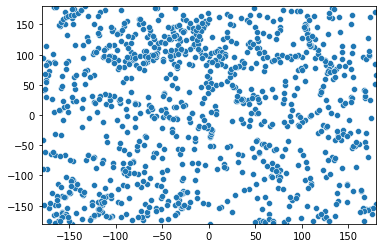

In [232]:
rama_plot(traj)
# [phi(i, phi_pair[0], phi_pair[1]).item() for i in traj]
# phi(traj[0], phi_pair[0], phi_pair[1])

In [466]:
import sampling.sampler
from sampling.sampler import Sampler
import jax.numpy as jnp
import pandas as pd
from seaborn import histplot


In [509]:
# energ = lambda x : (x**2).sum()/5
energ = lambda x : forces.compute(jnp.reshape(x, pos.shape), box)
value_grad = jax.value_and_grad(energ)


class MD():
  
    def __init__(self, d):
        self.d = d

    def grad_nlogp(self, x):
        """should return nlogp and gradient of nlogp"""
        return value_grad(x)

    def transform(self, x):
        # return x[:1] 
        return x
    
    # def 


(1000, 10)


<Axes: xlabel='x', ylabel='Count'>

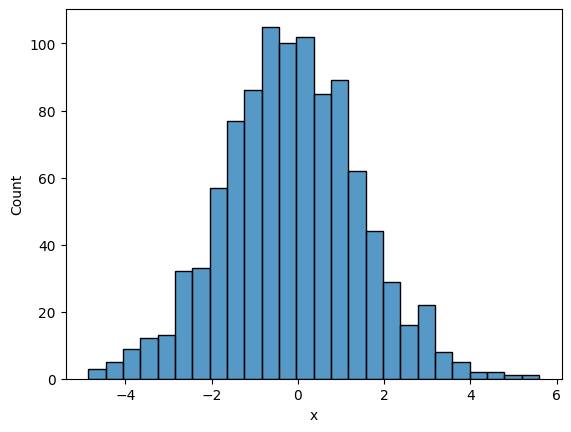

In [506]:
target = MD(prod(pos.shape))
sampler = Sampler(target)

samples = sampler.sample(1000, 1, x_initial=jnp.ones((10,)), random_key = jax.random.PRNGKey(0))


print(samples.shape)

data = pd.DataFrame(data = samples[:,0], columns=['x'])
histplot(data=data,x='x')

In [507]:
samples

Array([[-0.20574136,  0.50076469,  0.3049217 , ...,  1.60169381,
        -1.15921391, -2.54352237],
       [ 0.34518868,  0.04872355,  1.87760511, ...,  1.84992512,
        -0.95896098, -1.92207032],
       [ 0.30455644,  0.44020751,  1.98124842, ...,  0.51089947,
         0.3794461 , -0.46314269],
       ...,
       [ 1.65545037,  0.28467812,  1.84596088, ..., -1.21298695,
         1.33842253,  0.95066881],
       [ 1.09467664,  0.53757098,  0.38645324, ..., -1.4445249 ,
         1.50185841, -0.70067639],
       [-0.99773564, -0.63084634, -0.18156214, ...,  1.1652214 ,
         1.61615369, -1.96677391]], dtype=float64)